<a href="https://colab.research.google.com/github/kunan-au/Modeling_Risk/blob/main/Feature_Engineering_Doing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Factor Timing

Data From:

https://www.rba.gov.au/

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Package

In [ ]:
!pip install requests pandas matplotlib scipy statsmodels
!pip install yfinance
!pip show gspread
!pip install --upgrade gspread

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-Lib

In [ ]:
import requests
import pandas as pd
import gspread
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import talib
import yfinance as yf
import getpass
import re

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from google.colab import auth
from google.auth import default
from matplotlib.ticker import MaxNLocator
from oauth2client.service_account import ServiceAccountCredentials
from scipy.stats import pearsonr
from scipy.stats import pearsonr, skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

Data Importing

In [ ]:
#Setup for Google Sheets API
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
def get_sheet_data(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.drop(0)

    # Print columns to debug
    print("Columns in DataFrame:", df.columns)

    # Check if 'Date' column exists
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'].str.split().str[0], format='%m/%d/%Y').dt.date
    else:
        print(f"'Date' column not found in {spreadsheet_name}")

    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"'{col}' column not found in {spreadsheet_name}")

    return df

In [ ]:
sheet_names = ["MSFT", "META", "NFLX"]

dataframes = [get_sheet_data(name) for name in sheet_names]
combined_df = pd.concat(dataframes, ignore_index=True)

for df in dataframes:
    print(df.head())

In [ ]:
def get_sheet_data_updated(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()

    # The first row is the header
    header = data[0]
    # The first column 'Year' has no header, add it manually
    header[0] = 'Year'

    df = pd.DataFrame(data[1:], columns=header)

    # Convert 'Year' to datetime format
    if 'Annual' in spreadsheet_name:
        # Annual data, set 'Year' as the end of each year to forward fill
        df['Year'] = pd.to_datetime(df['Year']+'-12-31')
    else:
        # Monthly data
        df['Year'] = pd.to_datetime(df['Year'], format='%Y%m')

    # Convert numeric columns
    numeric_columns = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

In [ ]:
# Load the data
sheet_name_factors = ['F-F_Research_Data_5_Annual_Factors_2x3', 'F-F_Research_Data_5_Month_Factors_2x3']
factorframes = [get_sheet_data_updated(name) for name in sheet_name_factors]

# Ensure 'Year' column is datetime for both dataframes
factorframes[0]['Year'] = pd.to_datetime(factorframes[0]['Year'], format='%Y')
factorframes[1]['Year'] = pd.to_datetime(factorframes[1]['Year'], format='%Y%m')

# Set the index to 'Year' and sort it
annual_data = factorframes[0].set_index('Year').sort_index()
monthly_data = factorframes[1].set_index('Year').sort_index()

# Resample annual data to monthly, filling forward
# Note: The annual data is on the last day of the year, so we need to shift it to the first day
annual_data = annual_data.resample('MS').ffill()

# Combine the data
combined_data = pd.concat([monthly_data, annual_data]).sort_index().fillna(method='ffill')

# Reset the index if needed
combined_data = combined_data.reset_index()

# Print combined data to check
print(combined_data.head())

Revelant Factors Read


In [ ]:
def add_identifier(df, identifier):
    df['identifier'] = identifier
    return df

A1 RESERVE BANK OF AUSTRALIA - BALANCE SHEET

In [ ]:
def visualize_rba_balance_sheet(spreadsheet_name, worksheet_index=0):
    # Open the spreadsheet and select the worksheet
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()

    # Extract the date column starting from the 12th row
    date_column = [row[0] for row in data[11:]]  # Dates start at index 11 (12th row)
    data_columns = list(zip(*data[11:]))  # Transpose rows to columns

    # Clean the date column to ensure all dates are in correct format
    # This assumes dates are in the format 'Day-Month-Year'
    date_column_cleaned = []
    for date_str in date_column:
        try:
            # If the date format is different, adjust the format parameter accordingly
            date_column_cleaned.append(pd.to_datetime(date_str, format='%d-%b-%Y', errors='coerce'))
        except ValueError:
            date_column_cleaned.append(pd.NaT)  # Use NaT for any values that couldn't be converted

    # Initialize DataFrame with date column
    df = pd.DataFrame({"date": date_column_cleaned})

    # Define variable names based on the provided column names
    variable_names = [
        'Notes on issue', 'Exchange settlement balances', 'Deposits of overseas institutions',
        'Australian Government Deposits', 'State Governments Deposits', 'Other Deposits',
        'Other liabilities', 'Other reserves and current year earnings',
        'Capital and Reserve Bank Reserve Fund', 'Total liabilities and equity',
        'Gold and foreign exchange', 'Australian dollar investments',
        'Other assets (including clearing items)', 'Total assets'
    ]

    # Populate the DataFrame with the variables
    for i, name in enumerate(variable_names, start=1):
        df[name] = pd.to_numeric(data_columns[i], errors='coerce')

    # Visualize each variable over time
    for name in variable_names:
        plt.figure(figsize=(14, 7))
        sns.lineplot(x='date', y=name, data=df)
        plt.title(f'{name.replace("_", " ").title()} over Time')
        plt.xlabel('Date')
        plt.ylabel(f'{name} ($ million)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return df

In [ ]:
spreadsheet_name = 'A1 RESERVE BANK OF AUSTRALIA - BALANCE SHEET'
visualize_rba_balance_sheet(spreadsheet_name, 0)
balance_sheet_df = add_identifier(visualize_rba_balance_sheet('A1 RESERVE BANK OF AUSTRALIA - BALANCE SHEET'), 'Balance Sheet')

A3 Reserve Bank of Australia - Open Market Operations

In [ ]:
def visualize_rba_open_market_operations(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()

    date_column = [row[0] for row in data[12:]]  # Dates start at index 12 (13th row)
    data_columns = list(zip(*data[12:]))  # Transpose rows to columns

    column_indices = {
        'cash_position': 1,
        'outright_transactions_australian_govt': 2,
        'outright_transactions_state_territory_govts': 3,
        'foreign_exchange_swaps': 4,
        'repurchase_agreements_general_collateral': 5,
        'repurchase_agreements_private_securities': 6,
        'exchange_settlement_account_balances': 7,
        'overnight_repurchase_agreements': 8,
        'market_value_securities_held_under_reverse_repo_cgs': 9,
        'market_value_securities_held_under_reverse_repo_semis': 10,
        'market_value_securities_held_under_reverse_repo_other_government_related': 11,
        'market_value_securities_held_under_reverse_repo_adi_issued': 12,
        'market_value_securities_held_under_reverse_repo_asset_backed_securities': 13,
        'market_value_securities_held_under_reverse_repo_other': 14
    }

    df = pd.DataFrame({"date": pd.to_datetime(date_column)})
    for name, index in column_indices.items():
        df[name] = pd.to_numeric(data_columns[index], errors='coerce')

    for name in column_indices.keys():
        plt.figure(figsize=(14, 7))
        sns.lineplot(x='date', y=name, data=df)
        plt.title(f'{name.replace("_", " ").title()} over Time')
        plt.xlabel('Date')
        plt.ylabel(f'{name.replace("_", " ").title()} / $m')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return df

In [ ]:
# Use the actual name of your Google Sheet
spreadsheet_name = 'A3 Reserve Bank of Australia - Open Market Operations'
visualize_rba_open_market_operations(spreadsheet_name)
open_market_operations_df = add_identifier(visualize_rba_open_market_operations('A3 Reserve Bank of Australia - Open Market Operations'), 'Open Market Operations')

A3.1 HOLDINGS OF AUSTRALIAN GOVERNMENT SECURITIES AND SEMIS

In [ ]:
def visualize_holdings_data(spreadsheet_name, worksheet_index=0):
    # Open the spreadsheet and select the worksheet
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()

    # Extract the date column and the specified data columns starting from row 12
    date_column = [row[0] for row in data[11:]]  # Dates start at index 11 (12th row)
    data_columns = list(zip(*data[11:]))  # Transpose rows to columns

    # Column indices based on the spreadsheet structure
    column_indices = {
        "Australian Government Securities and Semis Holdings Total": 1,
        "AGS Total": 2,
        "Semis Total": 3,
        "Australian Government Bonds": 5,
        "Australian Government T-Notes": 6,
        "NSWTC Bonds": 7,
        "TCV Bonds": 8,
        "QTC Bonds": 9,
        "WATC Bonds": 10,
        "SAFA Bonds": 11,
        "TASC Bonds": 12,
        "NTTY Bonds": 13,
        "ACTT Bonds": 14
    }

    # Convert date column to datetime and initialize DataFrame with it
    df = pd.DataFrame({"date": pd.to_datetime(date_column)})

    # Add each data column to the DataFrame and convert to numeric
    for name, index in column_indices.items():
        df[name] = pd.to_numeric(data_columns[index], errors='coerce')

    # Plot each variable over time
    for name in column_indices.keys():
        plt.figure(figsize=(14, 7))
        sns.lineplot(x='date', y=name, data=df)
        plt.title(f'{name} over Time')
        plt.xlabel('Date')
        plt.ylabel(f'{name} / $m')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return df

In [ ]:
spreadsheet_name = 'A3.1 HOLDINGS OF AUSTRALIAN GOVERNMENT SECURITIES AND SEMIS'
visualize_holdings_data(spreadsheet_name)
holdings_data_df = add_identifier(visualize_holdings_data('A3.1 HOLDINGS OF AUSTRALIAN GOVERNMENT SECURITIES AND SEMIS'), 'Holdings Data')

Reshape Factors and Analysis

In [ ]:
final_df = pd.concat([balance_sheet_df, open_market_operations_df, holdings_data_df], axis=0, ignore_index=True)
print(final_df)

In [ ]:
def calculate_correlation(df, feature1, feature2):
    common_nonzero = df[(df[feature1] != 0) & (df[feature2] != 0)]
    if len(common_nonzero) < 2:
        return None  # Not enough data points
    corr, _ = pearsonr(common_nonzero[feature1], common_nonzero[feature2])
    return corr

In [ ]:
def feature_analysis_for_engineering(df):
    """
    Performs enhanced exploratory data analysis with larger histogram sizes,
    advanced analytics including PCA and feature importance using Random Forest.
    """
    # Replace NaN and inf with 0 for data cleaning
    df_cleaned = df.replace([np.inf, -np.inf, np.nan], 0)

    # Descriptive Statistics
    print("\n[Exploratory Data Analysis] Descriptive Statistics:")
    print(df_cleaned.describe())

    # Histograms and Box Plots Visualization
    numerical_features = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
    n_features = len(numerical_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols * 2  # Allocate rows for both histograms and box plots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*3))  # Increase figure size for clarity
    fig.suptitle('Numerical Features Analysis: Histograms and Box Plots Excluding Zeros')

    for i, feature in enumerate(numerical_features):
        non_zero_values = df_cleaned[feature][df_cleaned[feature] != 0]
        ax_hist = axs[i // n_cols * 2, i % n_cols]
        ax_box = axs[i // n_cols * 2 + 1, i % n_cols]
        if not non_zero_values.empty:
            sns.histplot(non_zero_values, bins='auto', ax=ax_hist)
            sns.boxplot(x=non_zero_values, ax=ax_box)
        else:
            ax_hist.text(0.5, 0.5, 'All values are 0', ha='center', va='center')
            ax_hist.axis('off')
            ax_box.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    # Skewness and Kurtosis
    print("\n[Skewness and Kurtosis Analysis]")
    for feature in numerical_features:
        print(f"{feature} - Skewness: {skew(df_cleaned[feature]):.2f}, Kurtosis: {kurtosis(df_cleaned[feature]):.2f}")

    # Improved Correlation Analysis
    print("\n[Correlation Analysis - Improved]")
    numerical_features = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
    correlations = []
    for i in range(len(numerical_features)):
        for j in range(i+1, len(numerical_features)):
            corr = calculate_correlation(df_cleaned, numerical_features[i], numerical_features[j])
            if corr is not None:  # Exclude pairs with correlation based entirely on zeros
                print(f"Correlation between {numerical_features[i]} and {numerical_features[j]}: {corr:.2f}")
            else:
                print(f"Excluded {numerical_features[i]} and {numerical_features[j]} due to insufficient data.")

    # Variability and Change Analysis
    print("\n[Variability and Change Analysis]")
    print(f"{'Feature':<30} {'Mean':<15} {'Standard Deviation':<15}")
    for feature in numerical_features:
        mean_value = df_cleaned[feature].mean()
        std_dev = df_cleaned[feature].std()
        print(f"{feature:<30} {mean_value:<15.2f} {std_dev:<15.2f}")

    # Segmentation Analysis if applicable
    if 'segment' in df_cleaned.columns:
        segments = df_cleaned['segment'].unique()
        print("\n[Segmentation Analysis]")
        for feature in numerical_features:
            print(f"\nFeature: {feature}")
            for segment in segments:
                segment_mean = df_cleaned[df_cleaned['segment'] == segment][feature].mean()
                segment_std = df_cleaned[df_cleaned['segment'] == segment][feature].std()
                print(f"Segment {segment} - Mean: {segment_mean:.2f}, Std Dev: {segment_std:.2f}")

    # Correlation Matrix Visualization
    if len(numerical_features) > 1:
        print("\n[Correlation Matrix Visualization]")
        correlation_matrix = df_cleaned[numerical_features].corr()
        plt.figure(figsize=(100, 80))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of Numerical Features')
        plt.show()


    # Advanced Analytics
    # Principal Component Analysis (PCA)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_cleaned[numerical_features])
    print("\n[PCA] Explained Variance Ratio:", pca.explained_variance_ratio_)

    # Feature Importance using Random Forest
    # Assuming a target variable 'y' exists. You might need to adjust this part.
    if 'target' in df_cleaned.columns:
        X = df_cleaned[numerical_features]
        y = df_cleaned['target']
        rf = RandomForestRegressor(n_estimators=100)
        rf.fit(X, y)
        importance = rf.feature_importances_
        print("\n[Random Forest Feature Importance]")
        for i, feature in enumerate(numerical_features):
            print(f"{feature}: {importance[i]:.4f}")

    # Missing Values Analysis (Proportion of Zeros)
    print("\n[Missing Values Analysis] Proportion of Zeros:")
    for feature in numerical_features:
        zeros = (df_cleaned[feature] == 0).mean()
        print(f"{feature}: {zeros:.2%} zeros")

    # Significant Yearly Changes Analysis
    time_column = df.columns[0]
    significant_change_threshold = 0.1

    print("\n[Significant Changes Analysis Based on the First Column]")
    for feature in numerical_features:
        print(f"\nAnalyzing significant changes in {feature}:")
        yearly_means = df.groupby(time_column)[feature].mean()
        yearly_changes = yearly_means.pct_change().fillna(0)
        significant_changes = yearly_changes[abs(yearly_changes) >= significant_change_threshold]
        if not significant_changes.empty:
            print(f"Significant changes detected in {feature}:")
            print(significant_changes)
        else:
            print(f"No significant changes detected in {feature} based on the threshold.")


    # Correlation Matrix Visualization with special handling
    plt.figure(figsize=(100, 80))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=correlation_matrix == 1)
    plt.title('Correlation Matrix of Numerical Features with Special Handling')
    plt.show()

In [ ]:
feature_analysis_for_engineering(final_df)

Genneral Function Failed

In [ ]:
RBA_sheet_names = ["A1 RESERVE BANK OF AUSTRALIA - BALANCE SHEET", "A2 RESERVE BANK OF AUSTRALIA – MONETARY POLICY CHANGES", "A3 Reserve Bank of Australia - Open Market Operations"
                  "A3 Reserve Bank of Australia - Open Market Operations","A3.1 HOLDINGS OF AUSTRALIAN GOVERNMENT SECURITIES AND SEMIS","A3.2 SECURITIES LENDING REPURCHASE TRANSACTIONS OF AUSTRALIAN GOVERNMENT SECURITIES AND SEMIS",
                   "A4 RESERVE BANK OF AUSTRALIA – FOREIGN EXCHANGE TRANSACTIONS AND HOLDINGS OF OFFICIAL RESERVE ASSETS","A5 RESERVE BANK OF AUSTRALIA - DAILY FOREIGN EXCHANGE MARKET INTERVENTION TRANSACTIONS",
                   "A6 RESERVE BANK OF AUSTRALIA – BANKNOTES ON ISSUE BY DENOMINATION","A7 RESERVE BANK OF AUSTRALIA – DETECTED AUSTRALIAN COUNTERFEITS BY DENOMINATION","B1 ASSETS OF FINANCIAL INSTITUTIONS",
                   "B2 BANKS – OFF-BALANCE SHEET BUSINESS","B11.1 INTERNATIONAL ASSETS OF THE AUSTRALIAN-LOCATED OPERATIONS OF BANKS AND RFCs","C1 Credit and Charge Cards – Seasonally Adjusted Series",
                   "C1.1 Credit and Charge Cards – Original Series – Aggregate Data","C1.3 Credit and Charge Cards – Market Shares of Card Schemes","C2 Debit Cards – Seasonally Adjusted Series",
                   "C2.1 Debit Cards – Original Series","C2.2 Prepaid Cards – Original Series","D1 GROWTH IN SELECTED FINANCIAL AGGREGATES","F5 INDICATOR LENDING RATES",
                   "F7 BUSINESS LENDING RATES","F8 PERSONAL LENDING RATES","F11.1 EXCHANGE RATES","F13 INTERNATIONAL OFFICIAL INTEREST RATES","G1 CONSUMER PRICE INFLATION","H1 GROSS DOMESTIC PRODUCT AND INCOME",
                   "I1 INTERNATIONAL TRADE AND BALANCE OF PAYMENTS"]

In [ ]:
def get_rba_sheet_data(spreadsheet_name, worksheet_index=0):
    creds, _ = default()
    gc = gspread.authorize(creds)

    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()

    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.drop(0)

    numeric_columns = get_numeric_columns(data[1:])  # Skip header row
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    return df

In [ ]:
def get_numeric_columns(data):
    numeric_cols = []
    for col in range(len(data[0])):  # Check each column
        try:
            if all(is_number(str(val)) for val in data[1:] if val not in [None, "", " "]):
                numeric_cols.append(data[0][col])
        except Exception as e:
            print(f"Error in column {col}: {e}")
    return numeric_cols

In [ ]:
def is_number(s):
    try:
        float(s)
        return True
    except (ValueError, TypeError):
        return False

In [ ]:
def find_start_row(df):
    date_pattern = re.compile(r'\d{2}-\w{3}-\d{4}')
    for i, row in df.iterrows():
        if date_pattern.search(str(row[0])):
            return i
    return None

In [ ]:
# Function to visualize financial factors
def visualize_financial_factors(data):
    # Convert the 'Publication date' column to datetime
    data['Publication date'] = pd.to_datetime(data['Publication date'])

    # Group by 'Publication date' and calculate the mean 'Coupon Rate' for that date
    grouped_data = data.groupby('Publication date').agg({'Coupon Rate': 'mean'})

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    grouped_data['Coupon Rate'].plot(ax=ax)

    # Annotations (you might want to customize the position or content of annotations)
    for idx, row in data.iterrows():
        ax.annotate(row['Identifier'], (row['Publication date'], row['Coupon Rate']),
                    textcoords="offset points", xytext=(0,10), ha='center')

    # Improve plot
    ax.set_title('Average Coupon Rate Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Coupon Rate (%)')
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()
    return plt

In [ ]:
# Function to visualize data from multiple sheets
def visualize_financial_factors_from_multiple_sheets(df_list):
    if 'Publication date' not in data.columns or 'Coupon Rate' not in data.columns:
      print("Required columns are not present in the dataframe.")
      return

    plots = []

    for df in df_list:
        # Find the start row containing the date
        start_row = find_start_row(df)
        if start_row is None:
            raise ValueError("No date found in the first column.")

        # Read the data from the start row
        data = df.iloc[start_row:].copy()
        data.columns = df.iloc[start_row - 1]
        data.reset_index(drop=True, inplace=True)

        # Convert date format
        data[data.columns[0]] = pd.to_datetime(data[data.columns[0]], errors='coerce')

        # Visualize each financial variable
        for column in data.columns[2:]:  # Assuming the first column is the date, second is the identifier
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(data[data.columns[0]], data[column], label=column)

            # Set chart
            ax.set_title(f'Time Series of {column}')
            ax.set_xlabel('Date')
            ax.set_ylabel(column)
            ax.legend()
            ax.grid(True)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.xticks(rotation=45)
            plt.tight_layout()

            plt.show()
            plots.append(plt)

    return plots

In [ ]:
def visualize_categorical_data(df, categorical_column, numerical_columns):
    plots = []

    for column in numerical_columns:
        # Create bar plot
        bar_plot = df.groupby(categorical_column)[column].mean().plot(kind='bar')
        plt.show()
        plots.append(bar_plot.figure)

        # Create box plot
        box_plot = df.boxplot(column=column, by=categorical_column, grid=False)
        plt.title(f'{column} by {categorical_column}')
        plt.suptitle('')  # Remove the default title
        plt.show()
        plots.append(box_plot.figure)

    return plots

In [ ]:
# Function to visualize significant relationships
def visualize_significant_relationships(df, date_column, numerical_columns, threshold=0.05):
    plots = []

    # Convert date column to datetime type
    df[date_column] = pd.to_datetime(df[date_column])

    # Iterate over each numerical variable
    for num_col in numerical_columns:
        # Iterate over each column in DataFrame to find relationships with numerical variables
        for col in df.columns:
            if df[col].dtype == 'object' or col == date_column:
                continue  # Skip non-numerical variables and the date column

            # Calculate the correlation between numerical variables
            correlation, p_value = stats.pearsonr(df[col], df[num_col])

            # If correlation is significant, visualize it
            if p_value < threshold:
                plt.figure(figsize=(10, 6))
                sns.regplot(x=col, y=num_col, data=df)
                plt.title(f'Relationship between {col} and {num_col} (p={p_value:.4f})')
                plt.show()
                plots.append(plt)

    return plots

In [ ]:
def check_sheets_in_excel(file_path):
    xls = pd.ExcelFile(file_path)
    sheet_names = xls.sheet_names  # Get all sheet names

In [ ]:
def main():
    RBA_sheet_names = RBA_sheet_names = ["A1 RESERVE BANK OF AUSTRALIA - BALANCE SHEET", "A2 RESERVE BANK OF AUSTRALIA – MONETARY POLICY CHANGES", "A3 Reserve Bank of Australia - Open Market Operations"
                  "A3 Reserve Bank of Australia - Open Market Operations","A3.1 HOLDINGS OF AUSTRALIAN GOVERNMENT SECURITIES AND SEMIS","A3.2 SECURITIES LENDING REPURCHASE TRANSACTIONS OF AUSTRALIAN GOVERNMENT SECURITIES AND SEMIS",
                   "A4 RESERVE BANK OF AUSTRALIA – FOREIGN EXCHANGE TRANSACTIONS AND HOLDINGS OF OFFICIAL RESERVE ASSETS","A5 RESERVE BANK OF AUSTRALIA - DAILY FOREIGN EXCHANGE MARKET INTERVENTION TRANSACTIONS",
                   "A6 RESERVE BANK OF AUSTRALIA – BANKNOTES ON ISSUE BY DENOMINATION","A7 RESERVE BANK OF AUSTRALIA – DETECTED AUSTRALIAN COUNTERFEITS BY DENOMINATION","B1 ASSETS OF FINANCIAL INSTITUTIONS",
                   "B2 BANKS – OFF-BALANCE SHEET BUSINESS","B11.1 INTERNATIONAL ASSETS OF THE AUSTRALIAN-LOCATED OPERATIONS OF BANKS AND RFCs","C1 Credit and Charge Cards – Seasonally Adjusted Series",
                   "C1.1 Credit and Charge Cards – Original Series – Aggregate Data","C1.3 Credit and Charge Cards – Market Shares of Card Schemes","C2 Debit Cards – Seasonally Adjusted Series",
                   "C2.1 Debit Cards – Original Series","C2.2 Prepaid Cards – Original Series","D1 GROWTH IN SELECTED FINANCIAL AGGREGATES","F5 INDICATOR LENDING RATES",
                   "F7 BUSINESS LENDING RATES","F8 PERSONAL LENDING RATES","F11.1 EXCHANGE RATES","F13 INTERNATIONAL OFFICIAL INTEREST RATES","G1 CONSUMER PRICE INFLATION","H1 GROSS DOMESTIC PRODUCT AND INCOME",
                   "I1 INTERNATIONAL TRADE AND BALANCE OF PAYMENTS"]

    all_dataframes = []

    for spreadsheet_name in RBA_sheet_names:
        try:
            df = get_rba_sheet_data(spreadsheet_name, worksheet_index=0)
            start_row = find_start_row(df)

            if start_row is not None:
                new_header = df.iloc[start_row]
                df = df[start_row + 1:]
                df.columns = new_header

                if 'Series ID' in df.columns:
                    df['Series ID'] = pd.to_datetime(df['Series ID'], errors='coerce')

                if 'SomeNumericColumn' in df.columns:
                    plt.figure(figsize=(10, 6))
                    plt.plot(df['Series ID'], df['SomeNumericColumn'], label='SomeNumericColumn')
                    plt.xlabel('Date')
                    plt.ylabel('Value')
                    plt.title(f'Data Visualization for {spreadsheet_name}')
                    plt.legend()
                    plt.show()

            all_dataframes.append(df)

        except Exception as e:
            print(f"An error occurred while processing document: {spreadsheet_name}")
            print(f"Error details: {e}")
            import traceback
            print(traceback.format_exc())

In [ ]:
# if __name__ == "__main__":
#     main()

Individual Stock Analysis

Basic

In [ ]:
# Price and Volume Plot for all DataFrames
for df, name in zip(dataframes, sheet_names):
    # Price and Volume Plot
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(df['Close'], label='Close Price')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.bar(df.index, df['Volume'], color='orange')
    plt.tight_layout()
    plt.show()
    print(f'Daily Closing Prices for {name}')
    print(f'Daily Volume for {name}')

    # Moving Average Plot
    plt.figure(figsize=(10, 6))
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA30'] = df['Close'].rolling(window=30).mean()
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['MA5'], label='5-Day MA')
    plt.plot(df['MA30'], label='30-Day MA')
    plt.legend()
    plt.show()
    print(f'Moving Averages for {name}')

    # Price Fluctuation Plot
    plt.figure(figsize=(10, 6))
    df['Price_Range'] = df['High'] - df['Low']
    plt.plot(df['Price_Range'])
    plt.show()
    print(f'Price Fluctuation for {name}')

    # Momentum Plot
    plt.figure(figsize=(10, 6))
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    plt.plot(df['Momentum'])
    plt.show()
    print(f'Momentum for {name}')

    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm')
    plt.show()
    print(f'Correlation Heatmap for {name}')

In [ ]:
# Calculate daily returns for each asset
returns_dict = {}

for asset_name, df in zip(sheet_names, dataframes):
    df['Returns'] = df['Close'].pct_change()
    returns_dict[asset_name] = df[['Date', 'Returns']].copy()

# Print the returns for each asset
for asset_name, returns_df in returns_dict.items():
    print(f"Asset: {asset_name}")
    print(returns_df.head())
    print("\n")

In [ ]:
def get_alpha_vantage_data(symbol, api_key, function="TIME_SERIES_DAILY"):
    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": function,
        "symbol": symbol,
        "apikey": api_key,
        "datatype": "json"
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    return data

In [ ]:
def process_alpha_vantage_data(data):
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df.apply(pd.to_numeric)
    df.index = pd.to_datetime(df.index)
    return df

In [ ]:
api_key = getpass.getpass("Please enter Alpha Vantage API key:")
symbol = "MSFT", "META", "NFLX"

raw_data = get_alpha_vantage_data(symbol, api_key)
print(raw_data)
df = process_alpha_vantage_data(raw_data)

In [ ]:
def get_sp500_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    return sp500

In [ ]:
sp500_df = get_sp500_data('2022-01-01', '2022-12-30')

print(sp500_df.head())

market_returns = sp500_df['Close'].pct_change()

ADV

In [ ]:
def get_risk_factors(start_date, end_date):
    try:
        ff_factors = yf.download("F-F_Research_Data_Factors_daily", start=start_date, end=end_date)

        if len(ff_factors.columns) == 4:
            ff_factors.columns = ['Market Risk Premium', 'SMB', 'HML', 'Risk Free Rate']
        elif len(ff_factors.columns) == 6:
            ff_factors.columns = ['Market Risk Premium', 'SMB', 'HML', 'Risk Free Rate', 'Column5', 'Column6']

        ff_factors = ff_factors / 100

        return ff_factors
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

Empty Sheet

In [ ]:
start_date = '2022-01-01'
end_date = '2022-12-31'
risk_factors = get_risk_factors(start_date, end_date)

if risk_factors is not None:
    print(risk_factors.head())
else:
    print("Failed to download risk factors.")

In [ ]:
def calculate_asset_returns(df):
    asset_returns = df['Close'].pct_change().dropna()

    return asset_returns

In [ ]:
def calculate_and_visualize_volatility(df, window=20):
    returns = df['Close'].pct_change().dropna()
    volatility = returns.rolling(window=window).std()
    plt.figure(figsize=(10, 6))
    plt.plot(volatility, label='Volatility')
    plt.title('Volatility Factor')
    plt.legend()
    plt.show()
    print("")

In [ ]:
def calculate_alpha_and_beta(asset_returns, market_returns):
    slope, intercept, r_value, p_value, std_err = stats.linregress(asset_returns, market_returns)
    alpha = intercept
    beta = slope
    return alpha, beta

In [ ]:
def calculate_and_visualize_sharpe_ratio(df, risk_free_rate=0.02):
    returns = df['Close'].pct_change().dropna()
    mean_return = returns.mean()
    volatility = returns.std()
    sharpe_ratio = (mean_return - risk_free_rate) / volatility

    plt.figure(figsize=(10, 6))
    plt.plot(returns, label='Asset Returns')
    plt.title('Asset Returns')
    plt.legend()
    plt.show()
    print("")

    print(f'Sharpe Ratio: {sharpe_ratio}')

In [ ]:
def calculate_and_visualize_r_squared(asset_returns, market_returns):
    r_squared = np.corrcoef(asset_returns, market_returns)[0, 1] ** 2
    print(f'R-Squared Value: {r_squared}')

In [ ]:
def calculate_and_visualize_technical_indicator(df, indicator='MA', window=20):
    if indicator == 'MA':
        df['Moving_Average'] = df['Close'].rolling(window=window).mean()
    elif indicator == 'RSI':
        delta = df['Close'].diff(1)
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        df['RSI'] = rsi
    elif indicator == 'Bollinger_Bands':
        df['MA'] = df['Close'].rolling(window=window).mean()
        df['Upper_Band'] = df['MA'] + 2 * df['Close'].rolling(window=window).std()
        df['Lower_Band'] = df['MA'] - 2 * df['Close'].rolling(window=window).std()

    plt.figure(figsize=(10, 6))
    if indicator == 'MA':
        plt.plot(df['Moving_Average'], label='Moving Average')
        plt.title('Moving Average')
        print("")
    elif indicator == 'RSI':
        plt.plot(df['RSI'], label='RSI')
        plt.title('Relative Strength Index (RSI)')
        print("")
    elif indicator == 'Bollinger_Bands':
        plt.plot(df['Close'], label='Close Price', alpha=0.5)
        plt.plot(df['Upper_Band'], label='Upper Bollinger Band')
        plt.plot(df['Lower_Band'], label='Lower Bollinger Band')
        plt.title('Bollinger Bands')
    plt.legend()
    plt.show()
    print("")

In [ ]:
def factor_model_analysis(asset_returns, market_returns, risk_factors):
    # Prepare the risk factors DataFrame with a constant for the OLS regression
    X = sm.add_constant(risk_factors)

    # Run the OLS regression
    model = sm.OLS(asset_returns, X).fit()

    # Print the summary of the regression
    print(model.summary())

    # Visualize the factor loadings
    plt.figure(figsize=(10, 6))
    plt.bar(X.columns[1:], model.params[1:])  # Skip the constant
    plt.xlabel('Risk Factors')
    plt.ylabel('Factor Loadings')
    plt.title('Factor Loadings for Asset Returns')
    plt.show()
    print("")

In [ ]:
def calculate_and_visualize_technical_indicator(df, indicator='MA', window=20):
    if indicator == 'MA':
        df['Moving_Average'] = df['Close'].rolling(window=window).mean()
        plt.figure(figsize=(10, 6))
        plt.plot(df['Moving_Average'], label='Moving Average')
        plt.title('Moving Average')
        plt.legend()
        print("")

In [ ]:
for df in dataframes:
    asset_returns = calculate_asset_returns(df)
    calculate_and_visualize_volatility(df)
    print("")
    calculate_and_visualize_sharpe_ratio(df)

    alpha, beta = calculate_alpha_and_beta(asset_returns, market_returns)
    print(f"Alpha: {alpha}, Beta: {beta}")

    calculate_and_visualize_r_squared(asset_returns, market_returns)
    print("")
    calculate_and_visualize_technical_indicator(df, 'MA')

    # Align asset_returns with risk_factors
    if 'risk_factors' not in df.columns:
        print("Risk factors are not in the DataFrame")
        continue

    risk_factors_aligned = risk_factors.loc[asset_returns.index]

    # Drop missing values
    asset_returns.dropna(inplace=True)
    risk_factors_aligned.dropna(inplace=True)

    # Ensure all inputs are aligned by index
    common_dates = asset_returns.index.intersection(risk_factors_aligned.index)
    asset_returns_aligned = asset_returns.loc[common_dates]
    risk_factors_aligned = risk_factors_aligned.loc[common_dates]

    # Run the factor model analysis
    factor_model_analysis(asset_returns_aligned, market_returns.loc[common_dates], risk_factors_aligned)

    # Print the head of the dataframe to check
    print(df.head())

S&P 500

In [ ]:
def get_sp500_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    return sp500

In [ ]:
def calculate_max_drawdown(return_series):
    cumulative_returns = (1 + return_series).cumprod()
    running_max = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown

In [ ]:
# Function to get S&P 500 data
def get_sp500_data(start_date, end_date):
    return yf.download('^GSPC', start=start_date, end=end_date)

In [ ]:
# Function to calculate max drawdown
def calculate_max_drawdown(return_series):
    cumulative_returns = (1 + return_series).cumprod()
    running_max = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - running_max) / running_max
    return drawdown

In [ ]:
# Adding technical indicators
def add_technical_indicators(df):
    df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
    df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)
    df.dropna(inplace=True)

In [ ]:
# Get the data
sp500_df = get_sp500_data('2000-01-01', '2022-12-30')

# Calculate returns and max drawdown
sp500_df['Returns'] = sp500_df['Close'].pct_change()
sp500_df['Max Drawdown'] = calculate_max_drawdown(sp500_df['Returns'])
sp500_df.dropna(inplace=True)

# Add technical indicators
add_technical_indicators(sp500_df)

# Feature scaling with RobustScaler to mitigate the effect of outliers
robust_scaler = RobustScaler()
scaled_features = robust_scaler.fit_transform(sp500_df[['Max Drawdown', 'Returns']])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
sp500_pca = pca.fit_transform(scaled_features)

# K-Means clustering on PCA-transformed data
kmeans = KMeans(n_clusters=3, random_state=0).fit(sp500_pca)
sp500_df['KMeans_Cluster'] = kmeans.labels_

# Prepare features and labels for the classification model
features = sp500_df[['SMA_50', 'RSI_14', 'Volume', 'Max Drawdown', 'Returns']]
labels = sp500_df['KMeans_Cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# Oversampling with SMOTE to balance the classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_resampled, y_resampled)

# Cross-validated score
scores = cross_val_score(rf_classifier, X_resampled, y_resampled, cv=5)
print(f"Cross-validated scores: {scores.mean()}")

# Make predictions
predictions = rf_classifier.predict(X_test)

# Classification report and accuracy
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

# Visualization of PCA-transformed features
plt.figure(figsize=(30, 18))
sns.scatterplot(x=sp500_pca[:, 0], y=sp500_pca[:, 1], hue=kmeans.labels_, palette='viridis')
plt.title('PCA of S&P 500 Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
print()

# Visualization of clustering results on original features
plt.figure(figsize=(30, 18))
sns.scatterplot(x=sp500_df.index, y=sp500_df['Max Drawdown'], hue=sp500_df['KMeans_Cluster'], palette='viridis')
plt.title('K-Means Clustering Results on S&P 500 Data')
plt.xlabel('Date')
plt.ylabel('Max Drawdown')
plt.legend(title='Cluster')
plt.show()

S&P / ASX 200

[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cross-validated scores: 0.9873777103382182
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.97      1.00      0.99        36
           2       1.00      1.00      1.00       138

    accuracy                           0.99       193
   macro avg       0.99      0.98      0.99       193
weighted avg       0.99      0.99      0.99       193

Accuracy: 0.9948186528497409


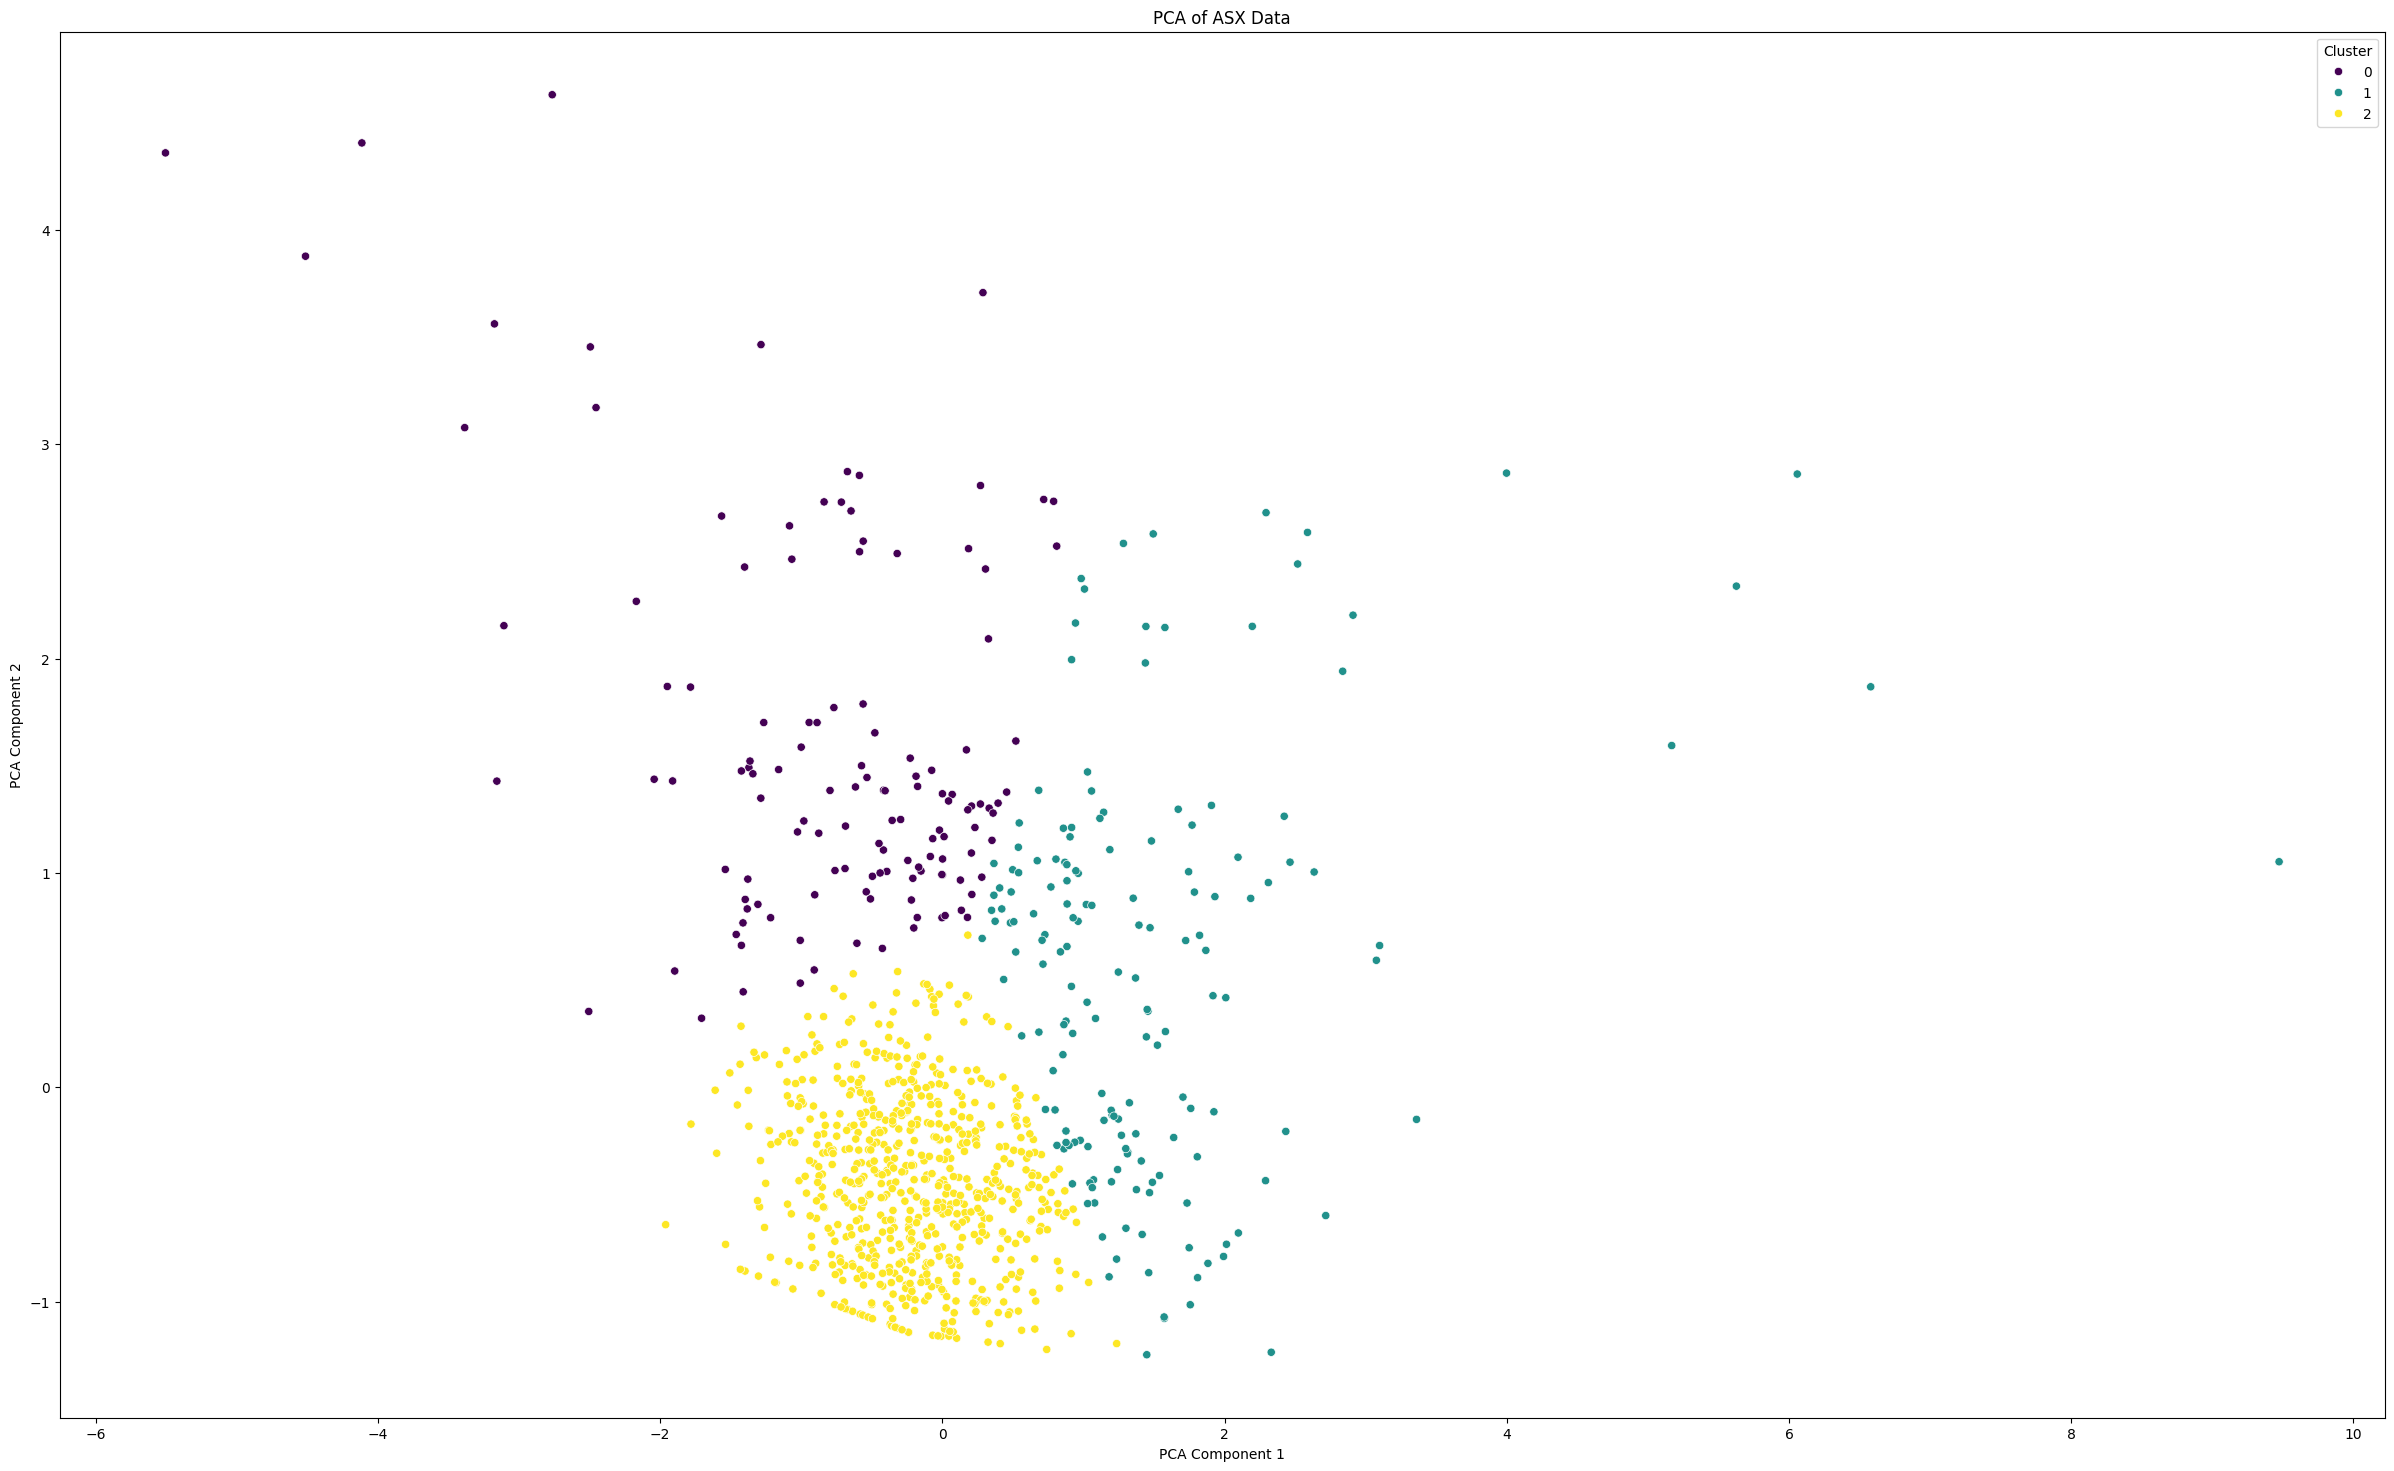

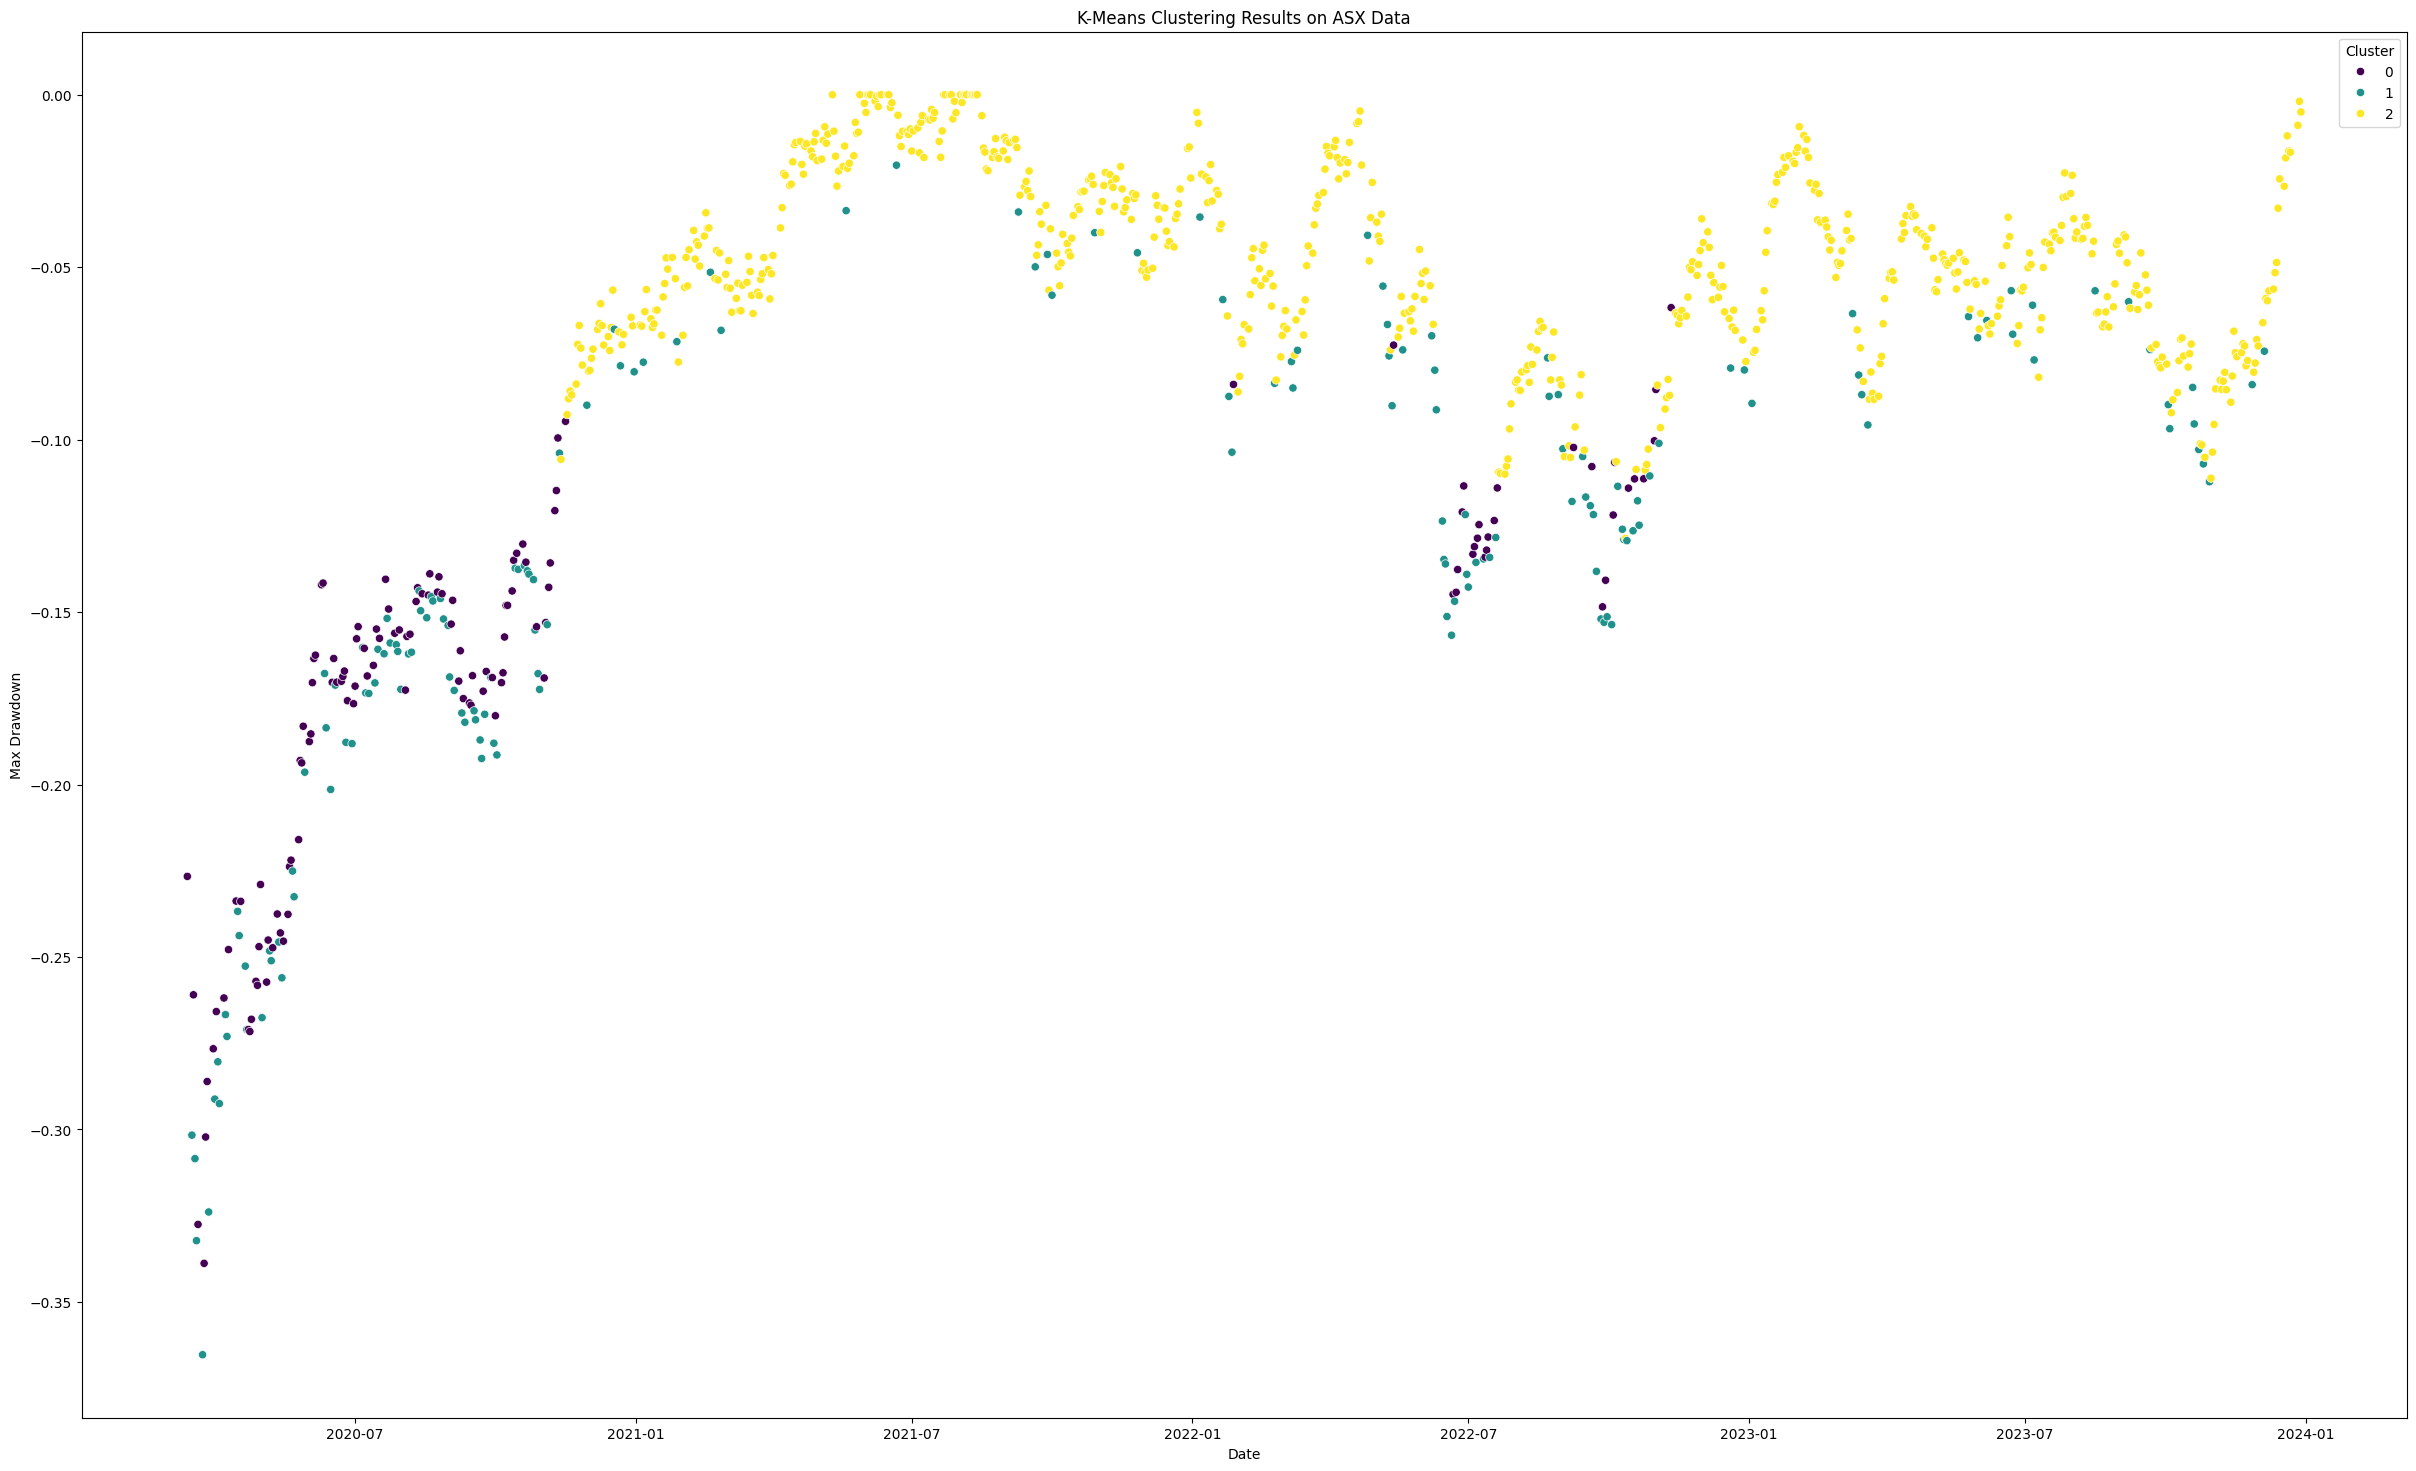

In [95]:
symbol = '^AXJO'
asx_df = yf.download(symbol, start="2020-01-01", end="2023-12-31")

asx_df['Returns'] = asx_df['Adj Close'].pct_change()
asx_df['Max Drawdown'] = calculate_max_drawdown(asx_df['Returns'])
asx_df.dropna(inplace=True)

add_technical_indicators(asx_df)

robust_scaler = RobustScaler()
scaled_features = robust_scaler.fit_transform(asx_df[['Max Drawdown', 'Returns']])

pca = PCA(n_components=2)
asx_pca = pca.fit_transform(scaled_features)

kmeans = KMeans(n_clusters=3, random_state=0).fit(asx_pca)
asx_df['KMeans_Cluster'] = kmeans.labels_

features = asx_df[['SMA_50', 'RSI_14', 'Volume', 'Max Drawdown', 'Returns']]
labels = asx_df['KMeans_Cluster']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_resampled, y_resampled)

scores = cross_val_score(rf_classifier, X_resampled, y_resampled, cv=5)

predictions = rf_classifier.predict(X_test)

print(f"Cross-validated scores: {scores.mean()}")
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

plt.figure(figsize=(30, 18))
sns.scatterplot(x=asx_pca[:, 0], y=asx_pca[:, 1], hue=kmeans.labels_, palette='viridis')
plt.title('PCA of ASX Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
print()

plt.figure(figsize=(30, 18))
sns.scatterplot(x=asx_df.index, y=asx_df['Max Drawdown'], hue=asx_df['KMeans_Cluster'], palette='viridis')
plt.title('K-Means Clustering Results on ASX Data')
plt.xlabel('Date')
plt.ylabel('Max Drawdown')
plt.legend(title='Cluster')
plt.show()